In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from src.define_dataset import SentinelSpectraDataset
from models.autoencoder import ConvAutoencoder1D

In [2]:
# Function to generate synthetic data for demonstration
def generate_sample_data(num_samples=1000, seq_length=10, num_features=1):
    # Generate synthetic time series with sine waves of different frequencies
    data = []
    for _ in range(num_samples):
        # Create a sine wave with random frequency and phase
        freq = np.random.uniform(0.5, 5)
        phase = np.random.uniform(0, 2*np.pi)
        x = np.arange(seq_length)
        signal = np.sin(2 * np.pi * freq * x / seq_length + phase)

        # Add some noise
        noise = np.random.normal(0, 0.1, size=seq_length)
        signal = signal + noise

        # Normalize to [-1, 1]
        signal = signal / np.max(np.abs(signal))

        if num_features > 1:
            # Create multi-feature signals (just for demonstration)
            multi_signal = np.array([signal * (i+1)/num_features for i in range(num_features)])
            data.append(multi_signal)
        else:
            data.append(signal.reshape(1, -1))

    return np.array(data)

In [3]:
def validation(model, test_data_loader):
    model.eval()
    running_mse = 0
    num_batches = len(test_data_loader)
    with torch.no_grad():
        for data in test_data_loader:
            inputs = data[0].to('cpu')
            outputs, _ = model(inputs)
            running_mse += torch.mean((inputs - outputs) ** 2).cpu().numpy()

    val_mse = running_mse / num_batches
    return val_mse

In [4]:
def train_autoencoder(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_test_loss = 0
        for data in train_loader:
            inputs = data[0].to(device)

            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        with torch.no_grad():
            for test_data in test_loader:
                inputs = test_data[0].to(device)

                # Forward pass
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)

                epoch_test_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_mse = validation(model, test_loader)
        
        loss_history.append(avg_loss)
        test_loss_history.append(val_mse)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Test Loss: {val_mse:.6f}')

    return loss_history, test_loss_history

In [5]:
# Parameters
input_size = 10
batch_size = 64
num_epochs = 30
latent_dim = 2
in_channels = 1  # Number of features/channels

In [6]:
# Generate sample data
print("Generating synthetic data...")
data = generate_sample_data(num_samples=1000, seq_length=input_size, num_features=in_channels)

# Split into train and test
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Create DataLoader
train_tensor = torch.FloatTensor(train_data)
test_tensor = torch.FloatTensor(test_data)

train_dataset = TensorDataset(train_tensor)
test_dataset = TensorDataset(test_tensor)

Generating synthetic data...


In [7]:
data = SentinelSpectraDataset('./data/training_examples.csv')

train_size = int(0.8*len(data))
test_size = int(0.2*len(data))
train_dataset, test_dataset = random_split(data, [train_size, test_size]) # 80-20 split

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Initialize model
model = ConvAutoencoder1D(input_size=input_size, latent_dim=latent_dim, in_channels=in_channels)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Train the model
print("Training the model...")
loss_history, test_loss_history = train_autoencoder(model, train_loader, test_loader, num_epochs=num_epochs)

Model initialized with 16967 parameters
Training the model...
Epoch [5/30], Loss: 0.019609, Test Loss: 0.020477
Epoch [10/30], Loss: 0.013804, Test Loss: 0.015013
Epoch [15/30], Loss: 0.011031, Test Loss: 0.012631
Epoch [20/30], Loss: 0.011713, Test Loss: 0.012666
Epoch [25/30], Loss: 0.010329, Test Loss: 0.012032
Epoch [30/30], Loss: 0.009054, Test Loss: 0.011691


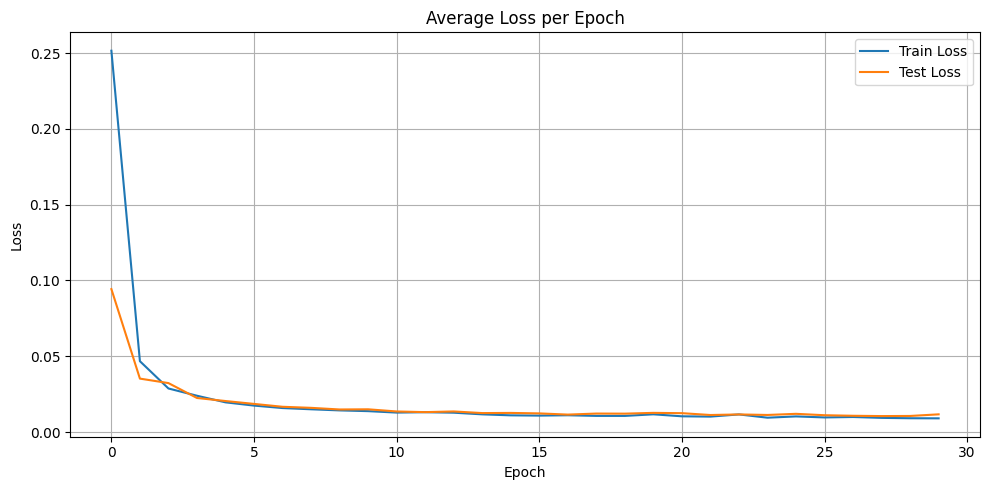

In [10]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 0.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

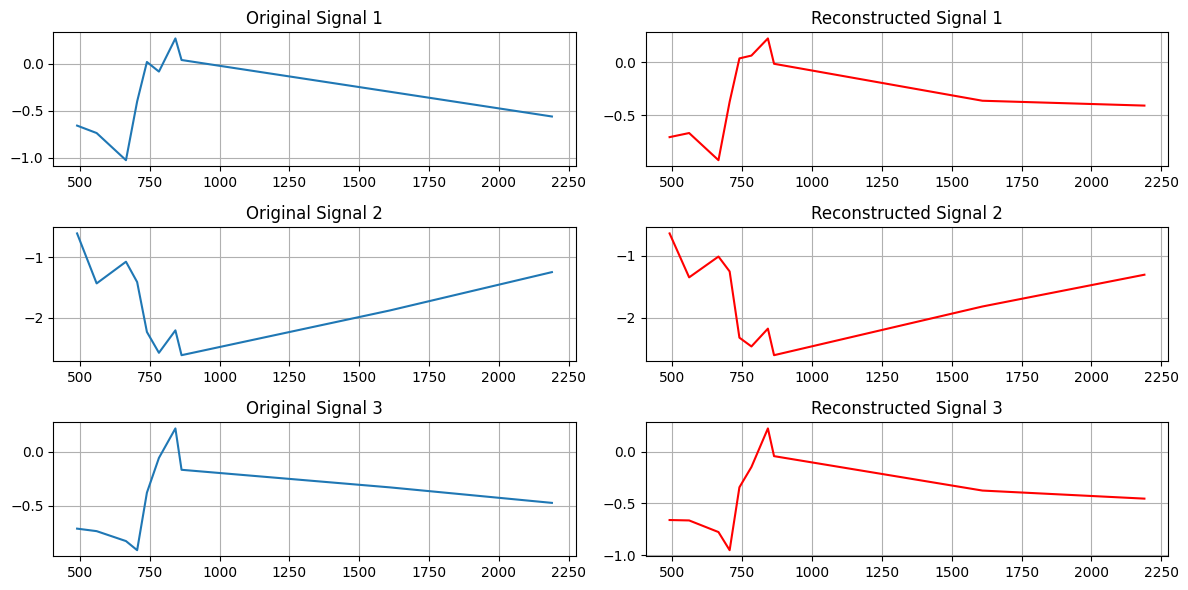

In [14]:
# Visualization of reconstruction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# band central wavelengths
wavelengths = [490, 560, 665, 705, 740, 783, 842, 864, 1610, 2190]

with torch.no_grad():
    # Get a sample from test data
    test_sample = test_dataset.dataset.data[test_dataset.indices[3:6]].to(device)
    reconstructed, _ = model(test_sample)

    # Plot original vs reconstructed
    plt.figure(figsize=(12, 6))
    for i in range(min(3, len(test_sample))):
        plt.subplot(3, 2, i*2+1)
        plt.plot(wavelengths, test_sample[i][0])
        plt.title(f"Original Signal {i+1}")
        # plt.ylim(0,0.4)
        plt.grid(True)
        
        plt.subplot(3, 2, i*2+2)
        plt.plot(wavelengths, reconstructed[i][0], 'r')
        plt.title(f"Reconstructed Signal {i+1}")
        # plt.ylim(0,0.4)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

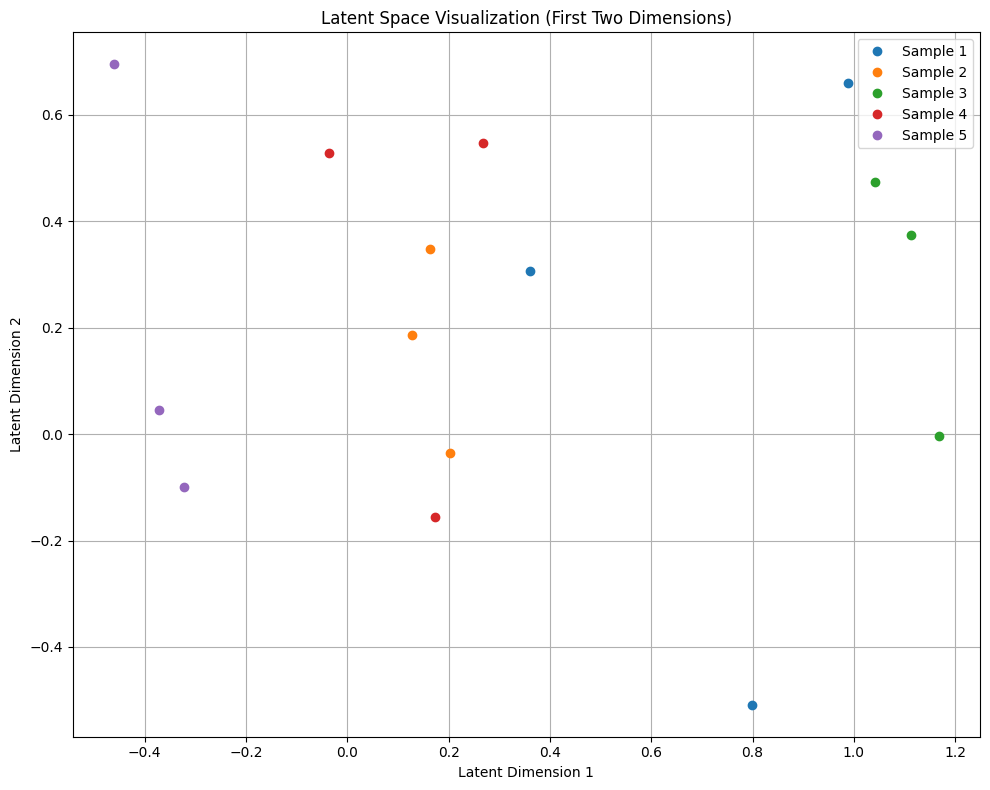

In [ ]:
with torch.no_grad():
    # Visualize the latent space for the test set
    encoded_data = []
    for data in test_loader:
        inputs = data[0].to(device)
        encoded = model.encode(inputs)
        encoded_data.append(encoded.cpu().numpy())
    
    encoded_data = np.vstack(encoded_data)
    
    # Plot first two dimensions of latent space
    if latent_dim >= 2:
        plt.figure(figsize=(10, 8))
        for i in range(min(5, encoded_data.shape[0])):
            plt.plot(encoded_data[i][0], encoded_data[i][1], 'o', label=f'Sample {i+1}')
        
        plt.title('Latent Space Visualization (First Two Dimensions)')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()